In [28]:
import pandas as pd
import numpy as np
import sqlite3
import statsmodels.formula.api as smf

from regtabletotext import prettify_result
from statsmodels.regression.rolling import RollingOLS
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import percent_format, date_format
from joblib import Parallel, delayed, cpu_count
from itertools import product

In [29]:
## load data
fintech_research_sql = sqlite3.connect(database="../data/fintech_research.sqlite")

crsp_monthly = (pd.read_sql_query(
    sql="SELECT permno, month, industry, ret_excess FROM crsp_monthly",
    con=fintech_research_sql,
    parse_dates={"month"})
  .dropna()
)

factors_ff3_monthly = pd.read_sql_query(
  sql="SELECT month, mkt_excess FROM factors_ff3_monthly",
  con=fintech_research_sql,
  parse_dates={"month"}
)

crsp_monthly = (crsp_monthly
  .merge(factors_ff3_monthly, how="left", on="month")
)

In [5]:
model_beta = (smf.ols(
    formula="ret_excess ~ mkt_excess",
    data=crsp_monthly.query("permno == 14593"))
  .fit()
)
prettify_result(model_beta)

OLS Model:
ret_excess ~ mkt_excess

Coefficients:
            Estimate  Std. Error  t-Statistic  p-Value
Intercept      0.010       0.005        2.004    0.046
mkt_excess     1.389       0.111       12.467    0.000

Summary statistics:
- Number of observations: 504
- R-squared: 0.236, Adjusted R-squared: 0.235
- F-statistic: 155.435 on 1 and 502 DF, p-value: 0.000



In [6]:
## rolling window estimates
def roll_capm_estimation(data, window_size, min_obs):
    """Calculate rolling CAPM estimation."""
    
    data = data.sort_values("month")

    result = (RollingOLS.from_formula(
      formula="ret_excess ~ mkt_excess",
      data=data,
      window=window_size,
      min_nobs=min_obs,
      missing="drop")
      .fit()
      .params.get("mkt_excess")
    )
    
    result.index = data.index
    
    return result

In [7]:
window_size = 60
min_obs = 48

valid_permnos = (crsp_monthly
  .dropna()
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query(f"counts > {window_size}+1")
)

permno_information = (crsp_monthly
  .merge(valid_permnos, how="inner", on="permno")
  .groupby(["permno"])
  .aggregate(first_month=("month", "min"),
             last_month=("month", "max"))
  .reset_index()
)

unique_permno = crsp_monthly["permno"].unique()
unique_month = factors_ff3_monthly["month"].unique()

all_combinations = pd.DataFrame(
  product(unique_permno, unique_month), 
  columns=["permno", "month"]
)

returns_monthly = (all_combinations
  .merge(crsp_monthly.get(["permno", "month", "ret_excess"]), 
         how="left", on=["permno", "month"])
  .merge(permno_information, how="left", on="permno")
  .query("(month >= first_month) & (month <= last_month)")
  .drop(columns=["first_month", "last_month"])
  .merge(crsp_monthly.get(["permno", "month", "industry"]),
         how="left", on=["permno", "month"])
  .merge(factors_ff3_monthly, how="left", on="month")
)

In [9]:
examples = pd.DataFrame({
  "permno": [14593, 10107, 93436, 17778],
  "company": ["Apple", "Microsoft", "Tesla", "Berkshire Hathaway"]
})

beta_example = (returns_monthly
  .merge(examples, how="inner", on="permno")
  .groupby(["permno"])
  .apply(lambda x: x.assign(
    beta=roll_capm_estimation(x, window_size, min_obs))
  )
  .reset_index(drop=True)
  .dropna()
)

/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipykernel_36248/3177277005.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


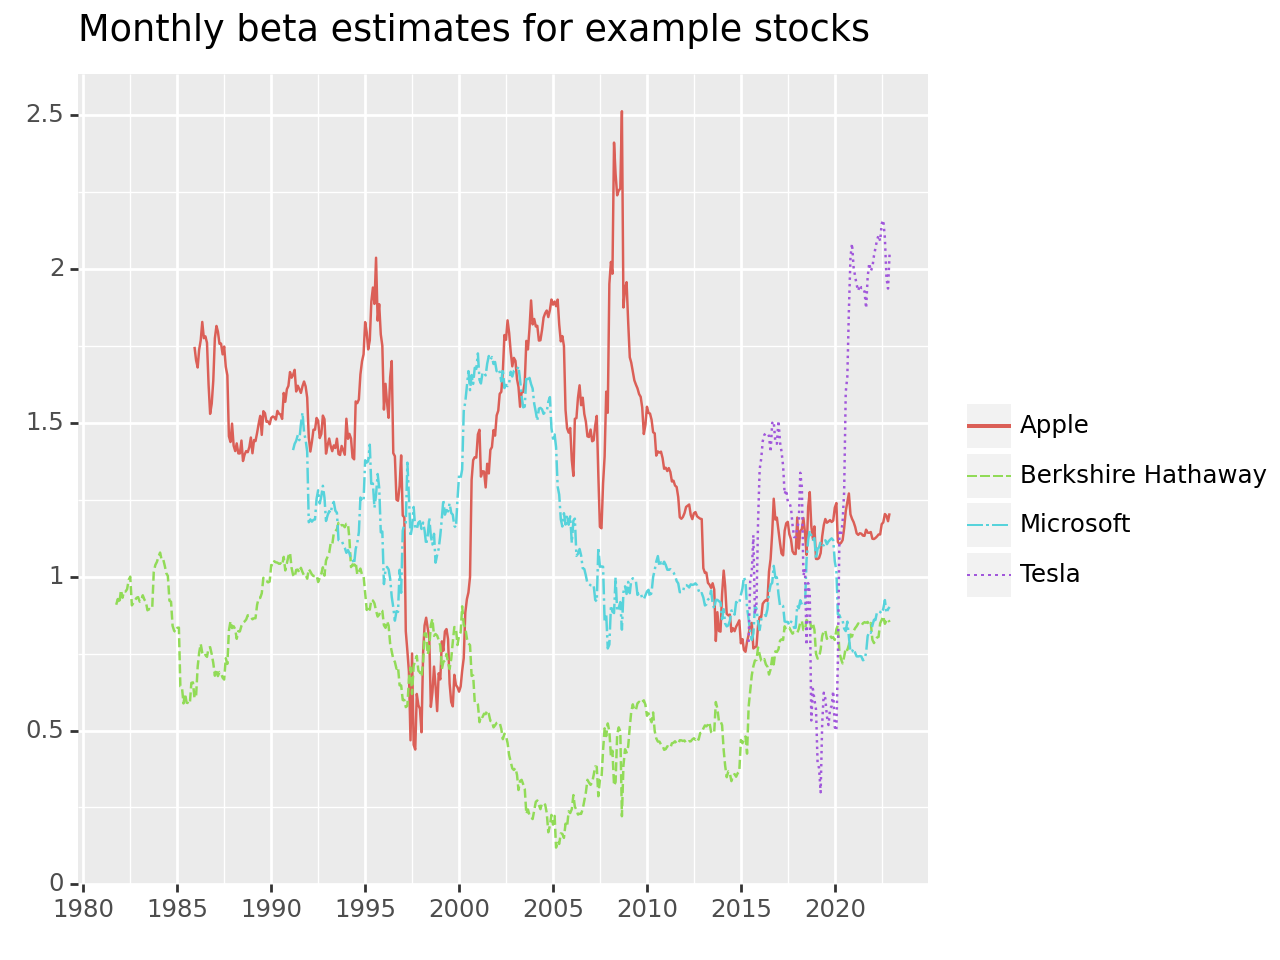

In [10]:
plot_beta = (
  ggplot(beta_example, 
         aes(x="month", y="beta", color="company", linetype="company")) + 
  geom_line() + 
  labs(x="", y="", color="", linetype="",
       title="Monthly beta estimates for example stocks") +
  scale_x_datetime(breaks=date_breaks("5 year"), labels=date_format("%Y")) 
)
plot_beta.draw()

In [11]:
## entire market
def roll_capm_estimation_for_joblib(permno, group):
    """Calculate rolling CAPM estimation using joblib."""
    
    if "date" in group.columns:
      group = group.sort_values(by="date")
    else:
      group = group.sort_values(by="month")

    beta_values = (RollingOLS.from_formula(
        formula="ret_excess ~ mkt_excess",
        data=group,
        window=window_size,
        min_nobs=min_obs,
        missing="drop"
      )
      .fit()
      .params.get("mkt_excess")
    )
    
    result = pd.DataFrame(beta_values)
    result.columns = ["beta"]
    result["month"] = group["month"].values
    result["permno"] = permno
    
    try:
      result["date"] = group["date"].values
      result = result[
        (result.groupby("month")["date"].transform("max")) == result["date"]
      ]
    except(KeyError):
      pass
    
    return result

In [12]:
permno_groups = (returns_monthly
  .merge(valid_permnos, how="inner", on="permno")
  .groupby("permno", group_keys=False)
)

n_cores = cpu_count()-1

beta_monthly = (
  pd.concat(
    Parallel(n_jobs=n_cores)
    (delayed(roll_capm_estimation_for_joblib)(name, group)
    for name, group in permno_groups)
  )
  .dropna()
  .rename(columns={"beta": "beta_monthly"})
)

beta_monthly

,beta_monthly,month,permno
59,0.097944,1991-01-01,10001
60,0.095307,1991-02-01,10001
61,0.090277,1991-03-01,10001
62,0.088877,1991-04-01,10001
63,0.092336,1991-05-01,10001
...,...,...,...
2847290,2.158801,2022-08-01,93436
2847291,2.100327,2022-09-01,93436
2847292,1.972512,2022-10-01,93436
2847293,1.936272,2022-11-01,93436


In [19]:
## beta using daily estimates

# factors_ff3_daily = pd.read_sql_query(
#   sql="SELECT date, mkt_excess FROM factors_ff3_daily",
#   con=fintech_research_sql,
#   parse_dates={"date"}
# )

# unique_date = factors_ff3_daily["date"].unique()

In [20]:
# window_size = 60
# min_obs = 50

# permnos = list(crsp_monthly["permno"].unique().astype(str))

# batch_size = 500
# batches = np.ceil(len(permnos)/batch_size).astype(int)

In [22]:
# beta_daily = []

# for j in range(1, batches+1):  
    
#     permno_batch = permnos[
#       ((j-1)*batch_size):(min(j*batch_size, len(permnos)))
#     ]
    
#     permno_batch_formatted = (
#       ", ".join(f"'{permno}'" for permno in permno_batch)
#     )
#     permno_string = f"({permno_batch_formatted})"
    
#     crsp_daily_sub_query = (
#       "SELECT permno, month, date, ret_excess "
#         "FROM crsp_daily "
#        f"WHERE permno IN {permno_string}" 
#     )
      
#     crsp_daily_sub = pd.read_sql_query(
#       sql=crsp_daily_sub_query,
#       con=tidy_finance,
#       dtype={"permno": int},
#       parse_dates={"date", "month"}
#     )
    
#     valid_permnos = (crsp_daily_sub
#       .groupby("permno")["permno"]
#       .count()
#       .reset_index(name="counts")
#       .query(f"counts > {window_size}+1")
#       .drop(columns="counts")
#     )
    
#     permno_information = (crsp_daily_sub
#       .merge(valid_permnos, how="inner", on="permno")
#       .groupby(["permno"])
#       .aggregate(first_date=("date", "min"),
#                  last_date=("date", "max"),)
#       .reset_index()
#     )
    
#     unique_permno = permno_information["permno"].unique()
    
#     all_combinations = pd.DataFrame(
#       product(unique_permno, unique_date), 
#       columns=["permno", "date"]
#     )
    
#     returns_daily = (crsp_daily_sub
#       .merge(all_combinations, how="right", on=["permno", "date"])
#       .merge(permno_information, how="left", on="permno")
#       .query("(date >= first_date) & (date <= last_date)")
#       .drop(columns=["first_date", "last_date"])
#       .merge(factors_ff3_daily, how="left", on="date")
#     )
    
#     permno_groups = (returns_daily
#       .groupby("permno", group_keys=False)
#     )
    
#     beta_daily_sub = (
#       pd.concat(
#         Parallel(n_jobs=n_cores)
#         (delayed(roll_capm_estimation_for_joblib)(name, group)
#         for name, group in permno_groups)
#       )
#       .dropna()
#       .rename(columns={"beta": "beta_daily"})
#     )
    
#     beta_daily.append(beta_daily_sub)
              
#     print(f"Batch {j} out of {batches} done ({(j/batches)*100:.2f}%)\n")
  
# beta_daily = pd.concat(beta_daily)

# beta_daily

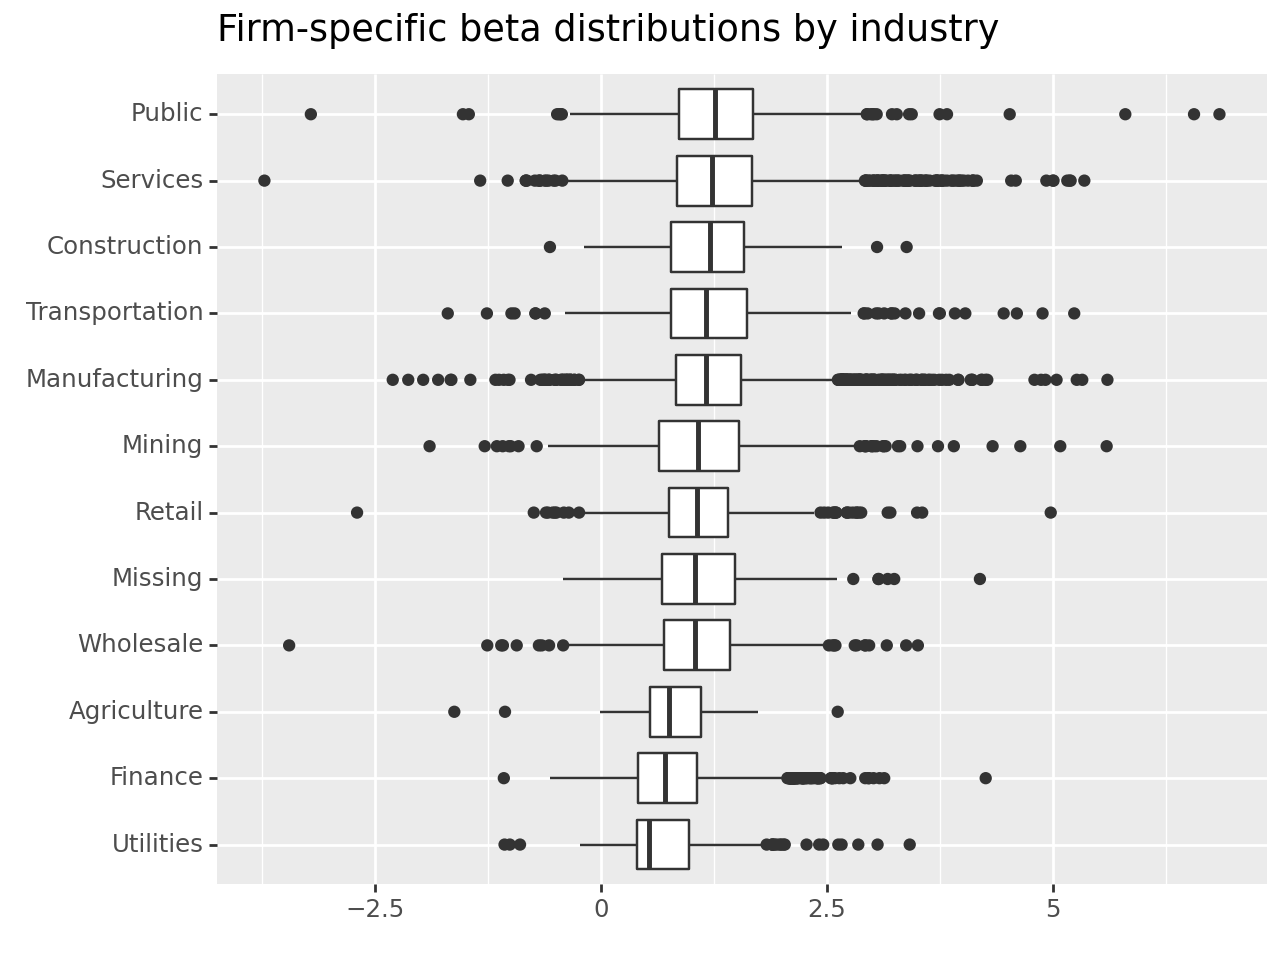

In [13]:
## compare beta

beta_industries = (beta_monthly
  .merge(crsp_monthly, how="inner", on=["permno", "month"])
  .dropna(subset="beta_monthly")
  .groupby(["industry","permno"])["beta_monthly"]
  .aggregate("mean")
  .reset_index()
)

industry_order = (beta_industries
  .groupby("industry")["beta_monthly"]
  .aggregate("median")
  .sort_values()
  .index.tolist()
)

plot_beta_industries = (
  ggplot(beta_industries, 
         aes(x="industry", y="beta_monthly")) +
  geom_boxplot() +
  coord_flip() +
  labs(x="", y="", 
       title="Firm-specific beta distributions by industry") +
  scale_x_discrete(limits=industry_order)
)
plot_beta_industries.draw()

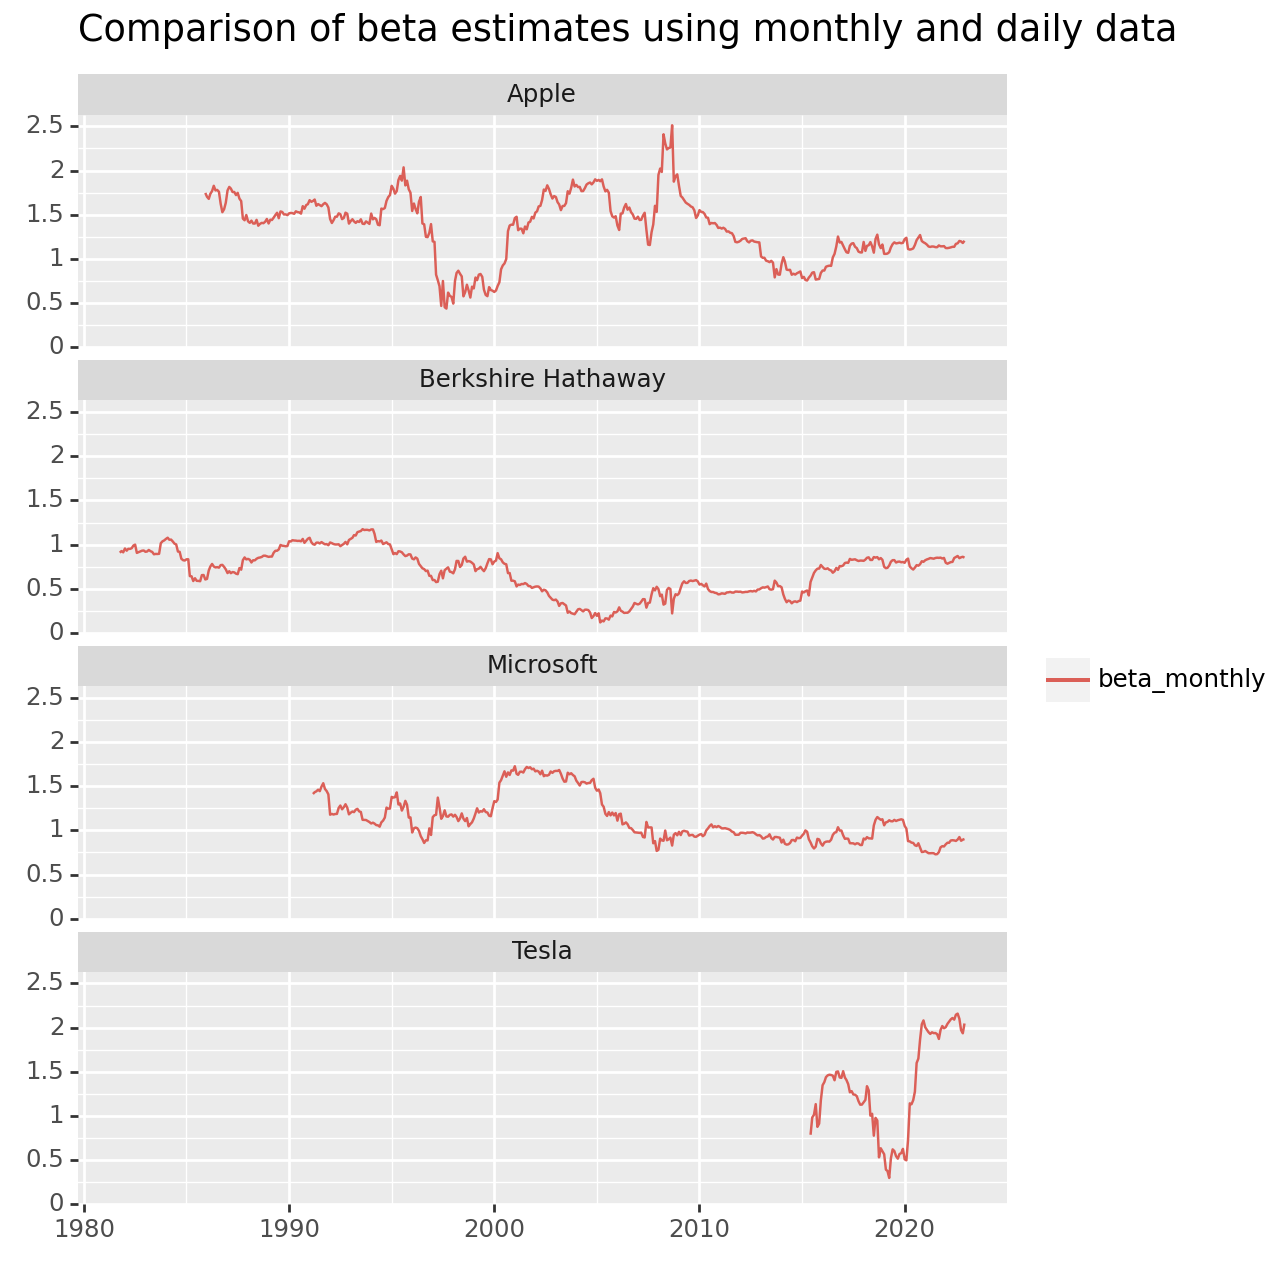

In [24]:
beta = beta_monthly.copy()
beta_comparison = (beta
  .merge(examples, on="permno")
  .melt(id_vars=["permno", "month", "company"], var_name="name",
        value_vars=["beta_monthly"], value_name="value")
  .dropna()
)

plot_beta_comparison = (
  ggplot(beta_comparison,
         aes(x="month", y="value", color="name")) +
  geom_line() +
  facet_wrap("~company", ncol=1) +
  labs(x="", y="", color="",
       title="Comparison of beta estimates using monthly and daily data") + 
  scale_x_datetime(breaks=date_breaks("10 years"), 
                   labels=date_format("%Y")) +
  theme(figure_size=(6.4, 6.4))
)
plot_beta_comparison.draw()


In [27]:
beta.to_sql(
  name="beta", 
  con=fintech_research_sql, 
  if_exists="replace",
  index=False
  )

1902895